# <center>🥂 Shaken Not Stirred 🃏</center>

# Imports and setup

In [10]:
from fluid import fluidsim
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt
from IPython.display import HTML


# diffusion coefficient of liquids

### Wilke and Chang Diffusion Coefficient

The **Wilke–Chang equation** is an empirical formula used to estimate the diffusion coefficient of two liquids

#### Equation


#### Reference
Wilke, C.R., and Chang, P. (1955).  
*Correlation of diffusion coefficients in dilute solutions.* **AIChE Journal**, 1(2), 264–270.  
https://doi.org/10.1002/aic.690010222


In [11]:
viscosities = {"gin": 1, "water": 1, "vermouth": 1}               # mPa.s double check values
molecular_weights = {"gin": 60, "water": 18, "vermouth": 130}     # g/mol
molar_volumes = {"gin": 46*0.4+18*0.6 #assuming 40% abv and the rest water
                , "water": 18
                , "vermouth": 46*0.2+18*0.8 #assuming 20% abv and the rest water
                } # cm^3/mol at boiling point

In [12]:
def wilke_chang_diffusion(solute="vermouth", solvent="gin", phi=2.6, temperature=290):
    """
    Estimate diffusion coefficient D_AB of a solute in a solvent
    using the Wilke-Chang equation.
    
    Parameters:
    - solute (str): Name of the solute
    - solvent (str): Name of the solvent
    - phi (float): Association factor (default: 2.6 for ethanol/water solvents)
    - temperature (float): Temperature in Kelvin

    Returns:
    - D_AB (float): Diffusion coefficient in cm^2/s
    """
    M_B = molecular_weights[solvent]  # g/mol
    mu_B = viscosities[solvent]       # g/(cm·s)
    V_A = molar_volumes[solute]       # cm^3/mol
    T_K = temperature                 # Temperature in Kelvin

    # Calculate diffusion coefficient using Wilke-Chang equation
    D_AB = (7.4e-8 * (phi * M_B) ** 0.5 * T_K) / (mu_B * (V_A ** 0.6))
    return D_AB

# Assume phi of gin and vermouth to be 2.6
# Assume temperature to be 290K
G_V_DIFFUSION = wilke_chang_diffusion(solute="vermouth", solvent="gin", phi=2.6, temperature=290)

# Running simulations

# stirring 

In [7]:
#change this for the right params
stirred = fluidsim(
        grid_size=100, 
        domain_size=20, 
        diffusion_coef=G_V_DIFFUSION,
        viscosity=0.02,
        dt=0.1,
        radius=10,
    )
    
stirred.source(x_pos=0, y_pos=0, volumeOfBlob=15.0, std=10)
print("Running simulation...")
conc_history, vel_history = stirred.looptheSim(steps=300)

Simulation initialized successfully.
Added blood source at position (0, 0) with volumeOfBlob 15.0 and radius 10.
Running simulation...
Running step 1/300
Total parts in grid: 9424.766921582275
Running step 21/300
Total parts in grid: 6536.55887015894
Running step 41/300
Total parts in grid: 3013.1368703829767
Running step 61/300
Total parts in grid: 73.58053536964607
Running step 81/300
Total parts in grid: 0.9242918627853326
Running step 101/300
Total parts in grid: 0.234601805729919
Running step 121/300
Total parts in grid: 0.011349592110523983
Running step 141/300
Total parts in grid: 0.0014331301555268175
Running step 161/300
Total parts in grid: 0.0016124321080514302
Running step 181/300
Total parts in grid: 0.0014400737734392988
Running step 201/300
Total parts in grid: 0.0008483760650791925
Running step 221/300
Total parts in grid: 4.80548835118173e-06
Running step 241/300
Total parts in grid: 1.0521978108020267e-08
Running step 261/300
Total parts in grid: 1.4680120801793896e-0

In [8]:
animation_stirred = stirred.visualisequiver(conc_history, vel_history)
animation_stirred.save('stirred.gif', writer='pillow', fps=20)  # Close the figure to prevent the animation from displaying
print("Animation saved...")
HTML(animation_stirred.to_jshtml())

Animation saved...


# shaking

In [7]:
#change this for the right params
shaken = fluidsim(
        grid_size=100, 
        domain_size=20, 
        diffusion_coef=G_V_DIFFUSION,
        viscosity=0.02,
        dt=0.1
    )
    
shaken.source(x_pos=0, y_pos=0, volumeOfBlob=15.0, std=10)
print("Running simulation...")
conc_history, vel_history = shaken.looptheSim(steps=50)

Simulation initialized successfully.
Added blood source at position (0, 0) with volumeOfBlob 15.0 and radius 10.
Running simulation...
Running step 1/50
Total parts in grid: 9424.766921582275
Running step 21/50
Total parts in grid: 11185.141466880737
Running step 41/50
Total parts in grid: 15115.418421530205


In [8]:
animation_shaken = shaken.visualisequiver(conc_history, vel_history)
animation_shaken.save('shaken.gif', writer='pillow', fps=20)
print("Animation saved...")
HTML(animation_shaken.to_jshtml())

Animation saved...


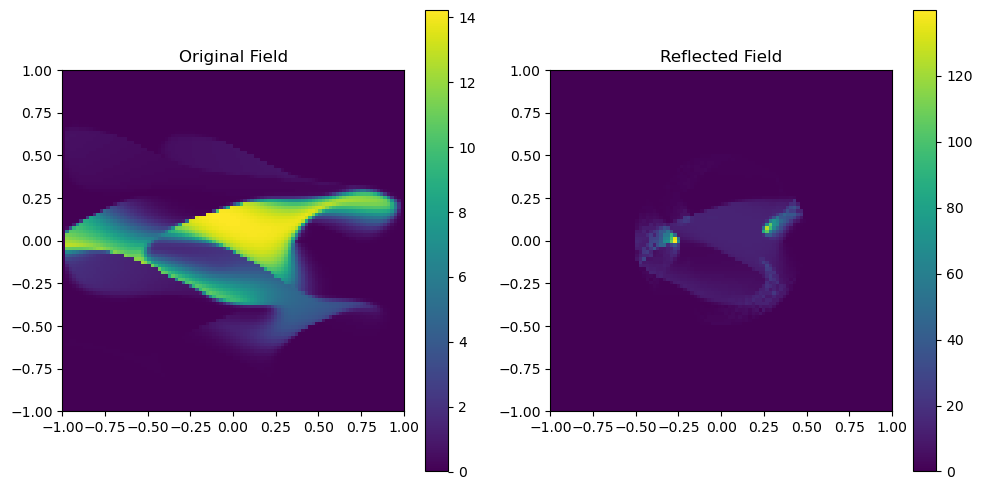

In [ ]:
def reflect_inside_circular_boundary(self, field):
    radius = self.boundary_radius/self.grid_size*2

    # Create coordinate grid
    x = np.linspace(-1, 1, self.grid_size)
    y = np.linspace(-1, 1, self.grid_size)
    X, Y = np.meshgrid(x, y)

    # Distance from center
    distance = np.sqrt(X**2 + Y**2)

    # Mask: outside the circular boundary
    outside = distance > radius

    # Initialize folded (reflected) field
    reflected_field = np.zeros_like(field)

    # Reflect positions of outside points
    X_out = X[outside]
    Y_out = Y[outside]
    F_out = field[outside]

    dx = X_out
    dy = Y_out
    r = np.sqrt(dx**2 + dy**2)
    dx_ref = dx * (radius / r)**2
    dy_ref = dy * (radius / r)**2
    X_ref = dx_ref
    Y_ref = dy_ref

    # Convert reflected coords to grid indices
    x_idx = np.clip(((X_ref + 1) / 2 * self.grid_size).astype(int), 0, self.grid_size - 1)
    y_idx = np.clip(((Y_ref + 1) / 2 * self.grid_size).astype(int), 0, self.grid_size - 1)

    # Accumulate reflected values into reflected_field
    for xi, yi, val in zip(x_idx, y_idx, F_out):
        reflected_field[yi, xi] += val

    # Add original values inside the circle
    reflected_field[~outside] += field[~outside]

    return reflected_field



# Apply the function and visualize
shaken.boundary_radius = 0.5  # Set the boundary radius for the simulation
abc = reflect_inside_boundary(shaken, shaken.concentration)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Field")
plt.imshow(shaken.concentration, extent=(-1, 1, -1, 1), cmap='viridis')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Reflected Field")
plt.imshow(abc, extent=(-1, 1, -1, 1), cmap='viridis')
plt.colorbar()

plt.tight_layout()
plt.show()

# Plot distributions

In [ ]:
def plot_distribution(fluidsimulation):

    grid = fluidsimulation.concentration.copy()

    # convert concentration to parts per million
    grid = grid * 1000000


    # Plot the final state using the figure method
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(grid, cmap='Blues', interpolation='nearest')
    cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
    cbar.set_label('Concentration (ppm)', rotation=270, labelpad=15)
    ax.axis('off')  # Remove x and y axis
    plt.title("Final State")
    plt.show()


    # Flatten the grid to get the distribution of values
    values = grid.flatten()

    sns.set_theme()
    dist_plot = sns.histplot(values, kde=True)
    dist_plot.set(xlabel='Concentration (ppm)')

    mean = np.mean(values)
    variance = np.var(values)

    # print how many parts in grid
    print(f"Total parts in grid: {np.sum(values)}")
    print(f"Mean concentration: {mean:.3g} ppm")
    print(f"Mean: {mean:.3g} ppm, Variance: {variance:.3g} ppm^2")

    
    return dist_plot

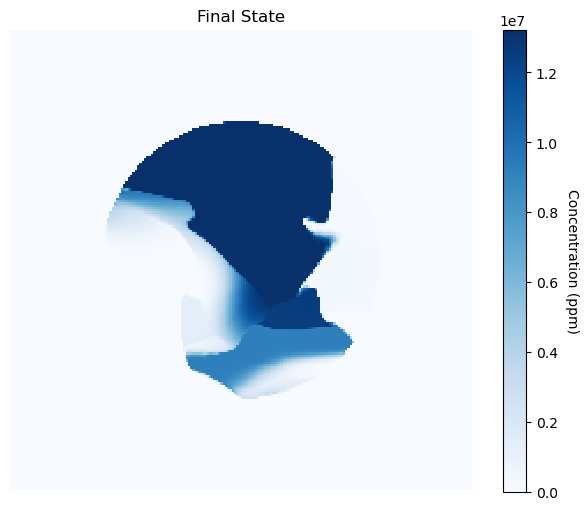

KeyboardInterrupt: 

In [ ]:
plot_distribution(stirred)

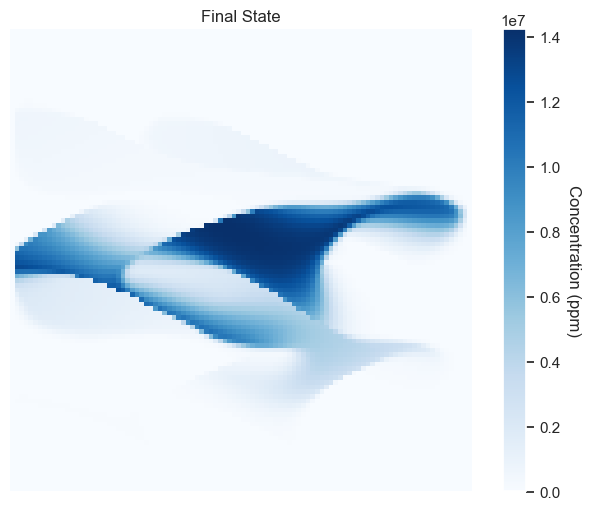

Total parts in grid: 15745936338.149652
Mean concentration: 1.57e+06 ppm
Mean: 1.57e+06 ppm, Variance: 1.17e+13 ppm^2


<AxesSubplot:xlabel='Concentration (ppm)', ylabel='Count'>

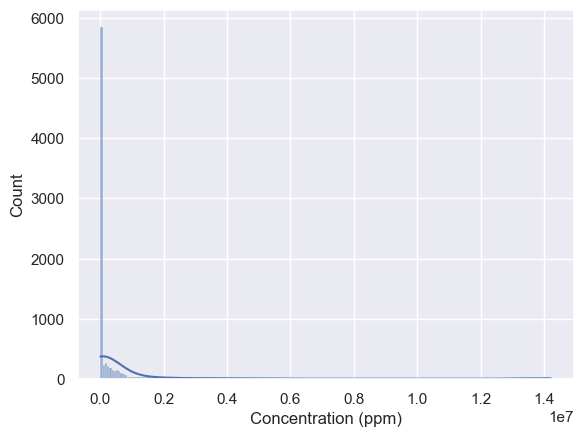

In [79]:
plot_distribution(shaken)

## double plot

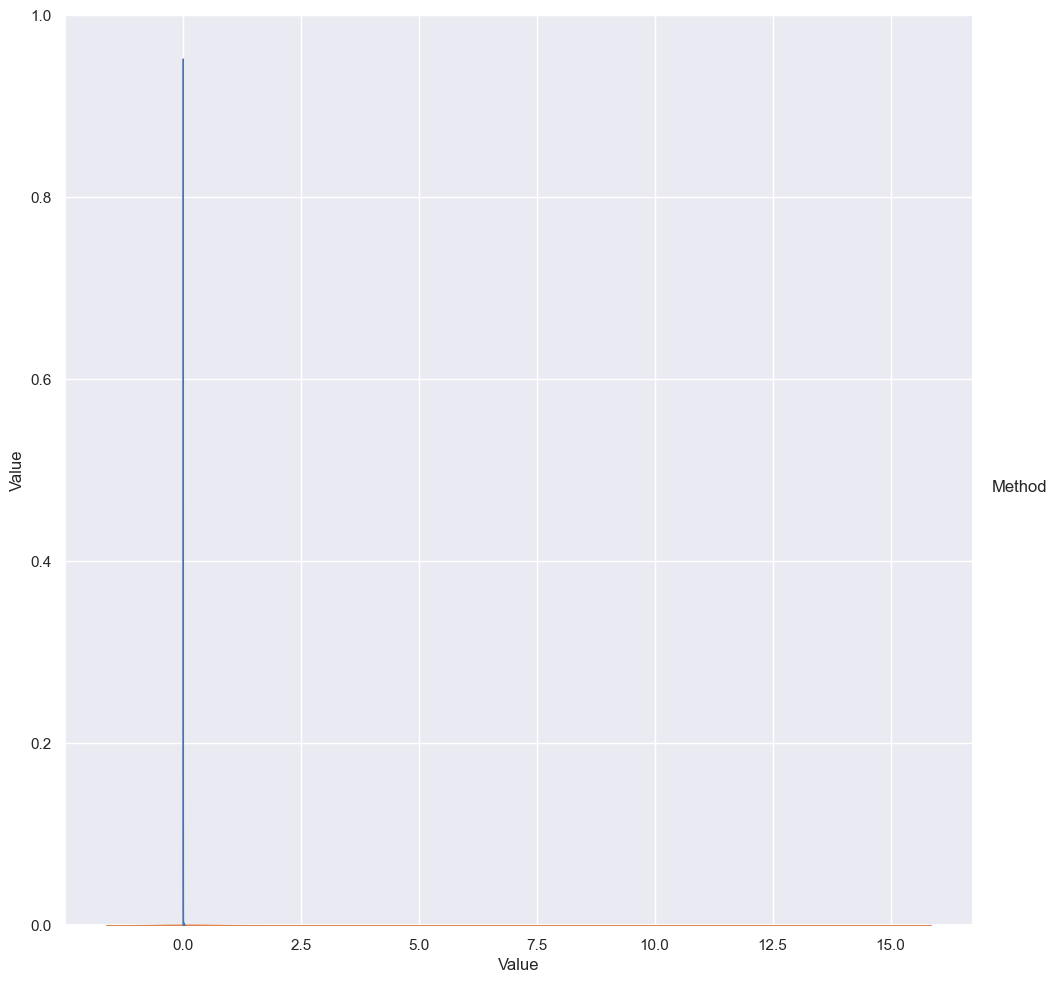

In [80]:
df_distributions = pd.DataFrame({
    'Value': np.concatenate([stirred.concentration.flatten(), shaken.concentration.flatten()]),
    'Method': ['Stirred'] * stirred.concentration.size + ['Shaken'] * shaken.concentration.size
})

sns.set_theme()
plot = sns.pairplot(df_distributions, hue="Method", height=10)
display(plot)


Signature:
map_coordinates(
    input,
    coordinates,
    output=None,
    order=3,
    mode='constant',
    cval=0.0,
    prefilter=True,
)
Docstring:
Map the input array to new coordinates by interpolation.

The array of coordinates is used to find, for each point in the output,
the corresponding coordinates in the input. The value of the input at
those coordinates is determined by spline interpolation of the
requested order.

The shape of the output is derived from that of the coordinate
array by dropping the first axis. The values of the array along
the first axis are the coordinates in the input array at which the
output value is found.

Parameters
----------
input : array_like
    The input array.
coordinates : array_like
    The coordinates at which `input` is evaluated.
output : array or dtype, optional
    The array in which to place the output, or the dtype of the
    returned array. By default an array of the same dtype as input
    will be created.
order : int, optional
 

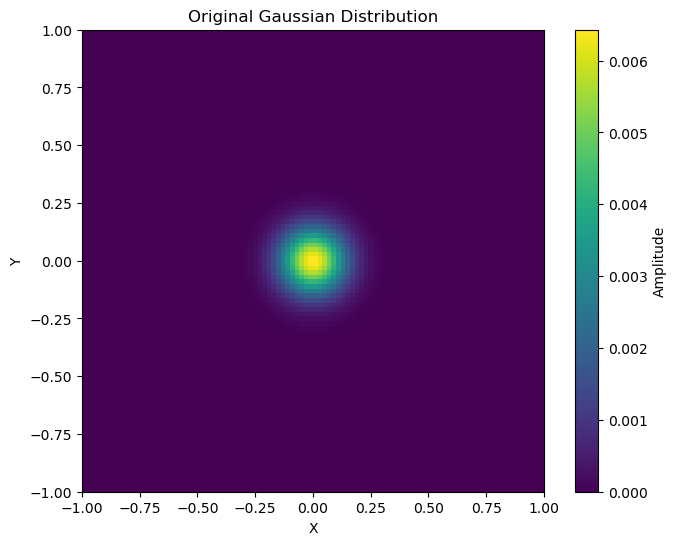

1.0


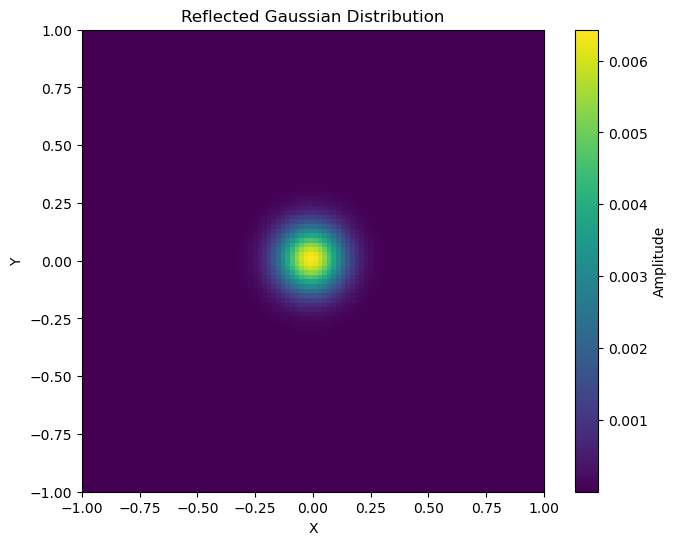

0.98007992947161


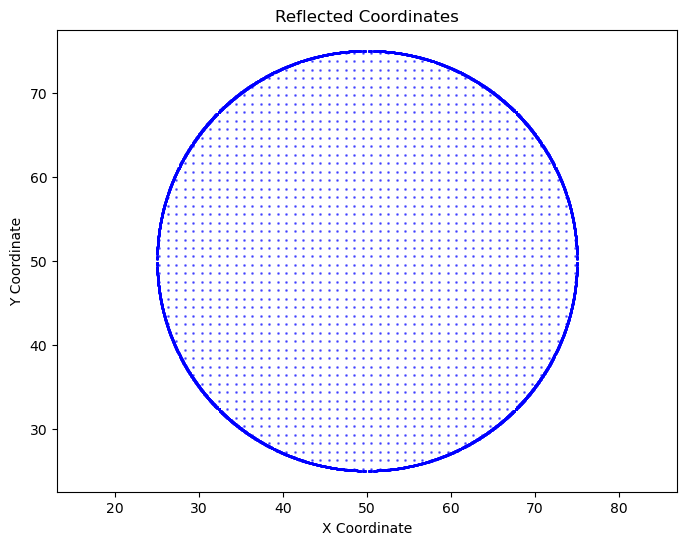

In [8]:
# Define grid size and radius
grid_size = 100
radius = 0.5  # Circle radius (touches the edge of the frame)

gauss = np.zeros((grid_size, grid_size))
# Create a Gaussian distribution
x = np.linspace(-1, 1, grid_size)
y = np.linspace(-1, 1, grid_size)
x, y = np.meshgrid(x, y)
gauss = np.exp(-(x**2 + y**2) / (2 * 0.1**2))
gauss /= gauss.sum()  # Normalize the Gaussian distribution

# Create a grid of coordinates
x = np.linspace(-1, 1, grid_size)
y = np.linspace(-1, 1, grid_size)
x, y = np.meshgrid(x, y)

# Calculate the distance from the center
distance_from_center = np.sqrt(x**2 + y**2)

# Create a circular mask
inside_circle = distance_from_center <= radius

# Reflect values outside the circle
x_reflected = np.where(inside_circle, x, x / distance_from_center * radius)
y_reflected = np.where(inside_circle, y, y / distance_from_center * radius)

# Map the Gaussian values to the reflected coordinates
reflected_gauss = map_coordinates(gauss, [grid_size * (y_reflected + 1) / 2, grid_size * (x_reflected + 1) / 2], order=1, mode='reflect')

# Plot the original Gaussian
plt.figure(figsize=(8, 6))
plt.imshow(gauss, extent=(-1, 1, -1, 1), cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title('Original Gaussian Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(gauss.sum())

# Plot the reflected Gaussian
plt.figure(figsize=(8, 6))
plt.imshow(reflected_gauss, extent=(-1, 1, -1, 1), cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title('Reflected Gaussian Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reflected_gauss.sum())

# Plot the reflected coordinates
plt.figure(figsize=(8, 6))
plt.scatter(grid_size * (x_reflected + 1) / 2, grid_size * (y_reflected + 1) / 2, s=1, c='blue', alpha=0.5)
plt.title('Reflected Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.axis('equal')
plt.show()


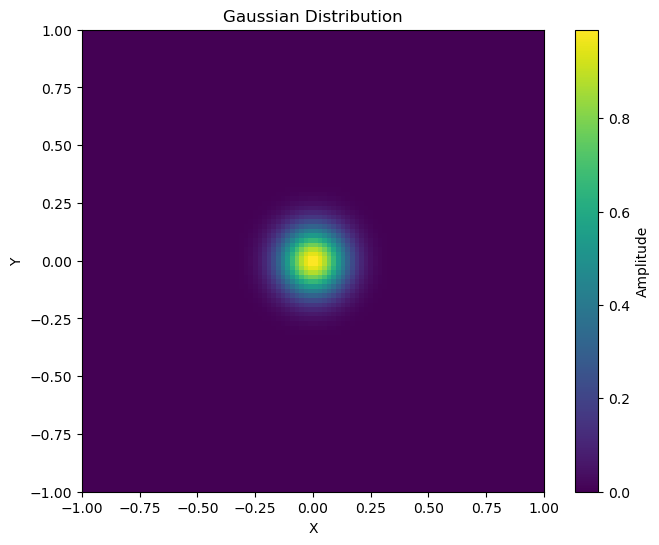

In [ ]:

# Define grid size
grid_size = 100

# Create a grid of coordinates
x = np.linspace(-1, 1, grid_size)
y = np.linspace(-1, 1, grid_size)
x, y = np.meshgrid(x, y)

# Define Gaussian parameters
sigma = 1
gauss = np.exp(-(x**2 + y**2) / (2 * sigma**2))

# Plot the Gaussian
plt.figure(figsize=(8, 6))
plt.imshow(gauss, extent=(-1, 1, -1, 1), cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title('Gaussian Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

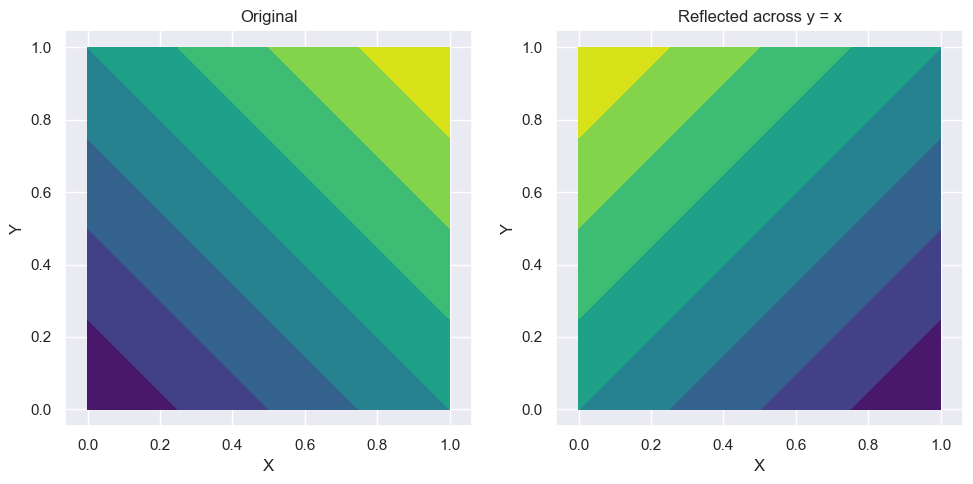

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Meshgrid over [0, 1] x [0, 1]
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Reflect across line y = x
X_ref, Y_ref = Y.copy(), X.copy()

# Visualize original and reflected grids
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.contourf(X, Y, X+Y, cmap='viridis')
plt.xlabel('X'), plt.ylabel('Y')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.title("Reflected across y = x")
plt.contourf(X_ref, Y_ref, X-Y, cmap='viridis')
plt.xlabel('X'), plt.ylabel('Y')
plt.axis('equal')

plt.tight_layout()
plt.show()


Original sum: 1555.0266 | Folded sum: 1555.0266


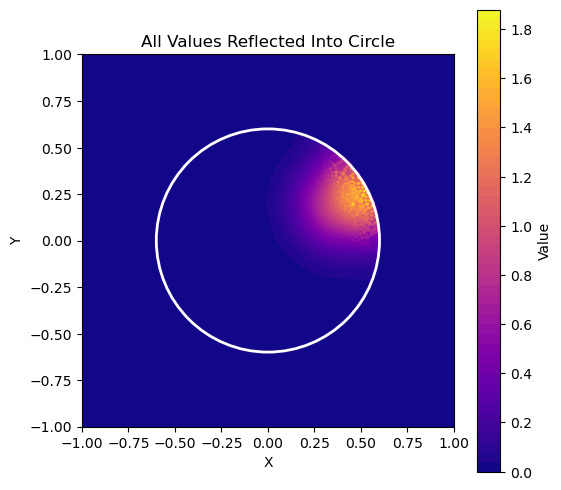

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Grid setup
grid_size = 200
x = np.linspace(-1, 1, grid_size)
y = np.linspace(-1, 1, grid_size)
X, Y = np.meshgrid(x, y)

# Circular boundary
radius = 0.6
center_x, center_y = 0, 0
distance = np.sqrt((X - center_x)**2 + (Y - center_y)**2)

# Some arbitrary scalar field (e.g., a Gaussian off-center)
Z = np.exp(-((X - 0.4)**2 + (Y - 0.2)**2) / 0.05)

# Initialize new concentration grid (everything will be folded into this)
Z_folded = np.zeros_like(Z)

# Mask for outside the circle
outside = distance > radius

# Get positions to reflect
X_out = X[outside]
Y_out = Y[outside]
Z_out = Z[outside]

# Reflect those positions inward (radial reflection)
dx = X_out - center_x
dy = Y_out - center_y
r = np.sqrt(dx**2 + dy**2)
dx_ref = dx * (radius / r)**2
dy_ref = dy * (radius / r)**2
X_ref = center_x + dx_ref
Y_ref = center_y + dy_ref

# Map reflected positions to grid indices
x_idx = np.clip(((X_ref + 1) / 2 * grid_size).astype(int), 0, grid_size - 1)
y_idx = np.clip(((Y_ref + 1) / 2 * grid_size).astype(int), 0, grid_size - 1)

# Accumulate reflected values
for xi, yi, val in zip(x_idx, y_idx, Z_out):
    Z_folded[yi, xi] += val

# Add all values that were already inside the circle
Z_folded[~outside] += Z[~outside]

# Check mass conservation
original_total = Z.sum()
folded_total = Z_folded.sum()
print(f"Original sum: {original_total:.4f} | Folded sum: {folded_total:.4f}")

# Plot result
plt.figure(figsize=(6, 6))
plt.contourf(X, Y, Z_folded, levels=50, cmap='plasma')
circle = plt.Circle((0, 0), radius, color='white', fill=False, linewidth=2)
plt.gca().add_artist(circle)
plt.gca().set_aspect('equal')
plt.title("All Values Reflected Into Circle")
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label="Value")
plt.show()

